# Load data

In [1]:
# imports
import numpy as np
import xarray as xr
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

from climatetranslation.unit.data import (
    get_dataset, 
    construct_regridders,
    get_land_mask as _get_land_mask,
    precip_kilograms_to_mm,
    dataset_time_overlap,
    kelvin_to_celcius,
)

import dask
from dask.diagnostics import ProgressBar
dask.config.set({'temporary_directory': '/home/s1205782/tmp'})

/home/s1205782/Datastore/miniconda3/envs/clim2clim2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = '/home/s1205782/geos-fulton/datadrive'
reduce_dict = {0: ['pr'], 2: ['tasmax'], 5500: ['z500']}

def add_title(ds, title):
    ds.attrs['title'] = title
    for k in ds.keys():
        ds[k].attrs['title'] = title
    ds.attrs['title'] = title

def get_dataset_plus(f):
    ds = get_dataset(f'{root}/{f}', level_vars=reduce_dict)
    ds = ds.sel(time=slice("1979-01-01", "2013-12-30"))
    ds = ds.squeeze('run', drop=True)
    return ds

In [3]:
era = get_dataset_plus('era5/all_hist_global_zarr')
had = get_dataset_plus('hadgem3/all_hist_zarr')
trans = get_dataset_plus('hadgem3/v8.2_monsoon_to_era5_40k')
combo = get_dataset_plus('/hadgem3/v8.2_monsoon_unit40k_and_qm_to_era5')
qm = get_dataset_plus('hadgem3/all_hist_qm_to_era_monsoon_zarr')

In [4]:
# regridding
rg_era, rg_had = construct_regridders(
    era, 
    had, 
    resolution_match='downscale', 
    scale_method='conservative', 
    periodic=False)

if rg_era is not None:
    era = rg_era(era)
if rg_had is not None:
    had = rg_had(had)

In [5]:
with ProgressBar(dt=10):
    era, had, trans, combo, qm = dask.compute([era, had, trans, combo, qm])[0]

[########################################] | 100% Completed |  4min 51.0s


In [6]:
for ds in [era, had, trans, combo, qm]:
    precip_kilograms_to_mm(ds)
    kelvin_to_celcius(ds)

In [7]:
add_title(era, 'ERA5')
add_title(had, 'HadGEM3')
add_title(trans, 'UNIT')
add_title(combo, 'UNIT+QM')
add_title(qm, 'QM')

In [8]:
from sklearn.preprocessing import quantile_transform as _quantile_transform

def quantile_transform(x):
    if isinstance(x, tuple):
        return tuple(quantile_transform(xn) for xn in x)
    if isinstance(x, xr.DataArray):
        da = xr.zeros_like(x)
        da.values[:] = quantile_transform(x.values)
        return da
    if len(x.shape)==1: 
        return _quantile_transform(x[:, None])[:, 0]
    else:
        return _quantile_transform(x)

In [14]:
def _quant_plot(x, ax, d=0.01):
    x = quantile_transform(x)
    ax.plot(*x, linestyle='', marker='.', alpha=0.2, markersize=2, zorder=-1);
    #ax.text(3,306, , {'fontsize':11}, ha='right', va='top')
    ax.annotate(x[1].attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
    sns.kdeplot(x=x[0], y=x[1], ax=ax, color='k', linewidths=1, alpha=.7, )
    ylim = (0-d,1+d) # ax.get_ylim()
    xlim = (0-d,1+d) # ax.get_xlim()
    
    #rect1 = matplotlib.patches.Rectangle((-1,-1), 1, 3, color='white',zorder=2)
    #ax.add_patch(rect1)

    #rect1 = matplotlib.patches.Rectangle((-1,-1), 3, 1, color='white',zorder=2)
    #ax.add_patch(rect1)
    
    #rect1 = matplotlib.patches.Rectangle((1,-1), 1, 3, color='white',zorder=2)
    #ax.add_patch(rect1)

    #rect1 = matplotlib.patches.Rectangle((-1,1), 3, 1, color='white',zorder=2)
    #ax.add_patch(rect1)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

def plot_vrac(xs, xlabel, ylabel, d=0.01):
    fig = plt.figure()
    s=1.3
    fig, axes = plt.subplots(3,2, figsize=(6*s,8*s), sharex=True, sharey=True)

    for x, ax in zip(xs, axes.flatten()[[0,2,3,4,5]]):
        _quant_plot(x, ax, d=d)

    for ax in axes[-1,:]:
        ax.set_xlabel(xlabel)
    for ax in axes[:,0]:
        ax.set_ylabel(ylabel)
    
    axes[0, -1].axis('off')

    return fig

# JS divergence functions

In [9]:
from scipy.special import kl_div
from operator import xor


def xor(a, b):
    """Return true if only one of a or b is true"""
    return (a or b) and not (a and b)


def bin_data(test_values, ref_values, n_bins, bins_x, bins_y):
    """Create binned estimates of density, maybe on the GPU."""
    
    # safety checks to make sure either 
    assert (bins_x is not None)==(bins_y is not None), (
        'bins_x and bins_y must either both be set or neither set'
    )
    assert xor(
        (n_bins is not None),  
        ((bins_x is not None) and (bins_y is not None))
    ), "either n_bins or (bins_x and bins_y) must be set, not both"
        
    def check_data_within_bins(arr, bins, prefix):
        m = f"{prefix} bin: array value {arr.min()} less than bin min {bins.min()}"
        assert arr.min()>= bins.min(), m
        m = f"{prefix} bin: array value {arr.max()} more than bin max {bins.max()}"
        assert arr.max()<=bins.max(), m

    def hist(x, y):        
        assert len(x)==len(y)
        n = len(x)
        
        if (bins_x is not None) and (bins_y is not None):
            check_data_within_bins(x, bins_x, 'x')
            check_data_within_bins(y, bins_y, 'y')
            result = np.histogram2d(x, y, bins=[bins_x, bins_y], density=False)
        else:
            result = np.histogram2d(
                x, y, 
                bins=n_bins, 
                range=[[xmin, xmax], [ymin, ymax]], 
                density=False
            )
        
        result = result[0].flatten()/n
        return result
    
    # create bins:
    if n_bins is not None:
        xmax = max([values[0].max() for values in [test_values, test_values]])
        ymax = max([values[1].max() for values in [test_values, test_values]])
        
        xmin = min([values[0].min() for values in [test_values, test_values]])
        ymin = min([values[1].min() for values in [test_values, test_values]])
    
    p = hist(*test_values)
    q = hist(*ref_values)
    
    return p, q


def est_js_div(test_values, ref_values, n_bins=None, bins_x=None, bins_y=None):
    """Empirically estimate the JS-divergence.
    
    You can either pass in x and y bins or select a number of bins, n_bins.
    If you select a number of bins is used it creates equally spaced bins.
    """
    p, q = bin_data(test_values, ref_values, n_bins, bins_x, bins_y)    
    m = (p+q)/2
    div = (kl_div(p, m) + kl_div(q, m)).sum()/2
    return div


def bootstrap_sample(x):
    n = len(x[0])
    inds = np.random.randint(0, n, n)
    return [a[inds] for a in x]
    

def js_value_and_bootstrap_results(test_values, ref_values, n_bins=None, bins_x=None, bins_y=None):
    """Calculates the JS-divergence value and the 5, 50 and 95% bootstrap values."""
    value = est_js_div(test_values, ref_values, n_bins, bins_x, bins_y)
    bootstrap_values = []
    for n in tqdm(range(200)):
        x_ref = bootstrap_sample(ref_values)
        x_test = bootstrap_sample(test_values)
        div = est_js_div(x_test, x_ref, n_bins, bins_x, bins_y)
        bootstrap_values += [div]
    return value, np.quantile(bootstrap_values, [0.05, 0.5, 0.95])

# FIGURE 9 - Hot days - temp vs pressure

In [10]:
# India Central 
lon_min = 72
lon_max = 85
lat_min = 8
lat_max = 28

In [11]:
def hot_days(ds, lon_min, lon_max, lat_min, lat_max):
    # get temp data only
    ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    temps_ave = ds.tasmax.mean(dim=('lat', 'lon'))
    # find hottest days
    hot_days = temps_ave.groupby('time.year').apply(
        lambda dx: dx.time.isel(time=dx.argmax(dim='time'))
    )
    return ds.sel(time=hot_days)

hot_days(had, lon_min, lon_max, lat_min, lat_max)

<xarray.Dataset>
Dimensions:  (year: 35, lat: 36, lon: 16)
Coordinates:
  * lat      (lat) float32 8.056 8.611 9.167 9.722 ... 25.83 26.39 26.94 27.5
  * lon      (lon) float32 72.08 72.92 73.75 74.58 ... 82.08 82.92 83.75 84.58
    time     (year) object 1979-06-04 12:00:00 ... 2013-06-04 12:00:00
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2009 2010 2011 2012 2013
Data variables:
    pr       (year, lat, lon) float32 16.19 11.87 7.397 ... 0.002054 0.001355
    tasmax   (year, lat, lon) float32 28.6 28.68 28.72 ... 46.09 45.93 43.71
    z500     (year, lat, lon) float32 5.853e+03 5.852e+03 ... 5.846e+03
Attributes:
    regrid_method:  conservative
    title:          HadGEM3

In [12]:
hotest_days_data = [
    hot_days(ds, lon_min, lon_max, lat_min, lat_max)
    for ds in [era, had, trans, combo, qm]
]

In [13]:
# Re-organise data
def transform_9(ds):
    return ds.tasmax.values.ravel().clip(None, np.inf), ds.z500.values.ravel()

In [286]:
[ds.tasmax.max() for ds in hotest_days_data]

[<xarray.DataArray 'tasmax' ()>
 array(46.62390137),
 <xarray.DataArray 'tasmax' ()>
 array(58.40200806),
 <xarray.DataArray 'tasmax' ()>
 array(50.81751139),
 <xarray.DataArray 'tasmax' ()>
 array(47.25522083),
 <xarray.DataArray 'tasmax' ()>
 array(47.25521851)]

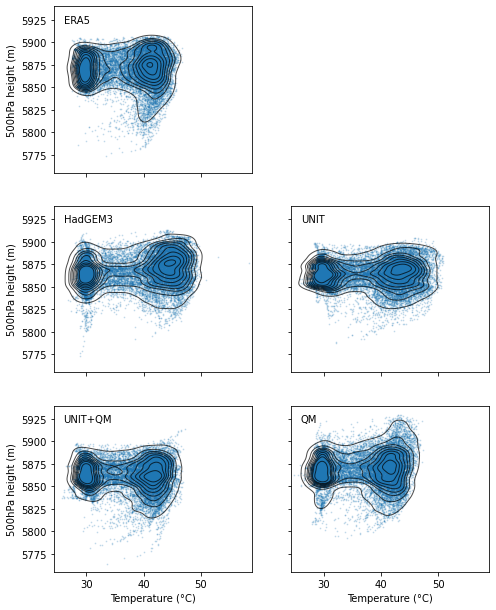

In [15]:
s = 1.3
def hot_pressure_plots(*hotest_days, figsize=(6*s,8*s)):

    fig, axes = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    axes_used = np.delete(axes.ravel(), 1)
    axes[0,1].axis('off')
    
    for ds, ax in zip(hotest_days, axes_used):
        x, y = transform_9(ds)
        ax.plot(x, y, linestyle='', marker='.', alpha=0.2, markersize=1.6, zorder=-1);
        sns.kdeplot(x=x, y=y, ax=ax, color='k', linewidths=1, alpha=.7)

        ax.set_xlim(None, 58.8)
        #ax.set_ylim(5640, 5920)
        #ax.tick_params(axis='x', labelsize=16)
        #ax.tick_params(axis='y', labelsize=16)
        ax.annotate(ds.attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')

        #ax.set_title(ds.attrs['title'], loc='left', x=0.04, y=1.0, pad=-20, fontsize=20)
        
    for ax in axes[:,0]:
        ax.set_ylabel('500hPa height (m)')
    for ax in axes[-1,:]:
        ax.set_xlabel('Temperature (°C)')
            
    
hot_pressure_plots(*[ds for ds in hotest_days_data])
#plt.savefig("india_hotdays_joint_TP.png", dpi=300)

In [18]:
hotest_days_data[0].stack(z=("year", "lat", 'lon'))

<xarray.Dataset>
Dimensions:  (year: 35, lat: 36, lon: 16)
Coordinates:
    time     (year) datetime64[ns] 1979-06-06 1980-05-25 ... 2013-05-22
  * lon      (lon) float32 72.08 72.92 73.75 74.58 ... 82.08 82.92 83.75 84.58
  * lat      (lat) float32 8.056 8.611 9.167 9.722 ... 25.83 26.39 26.94 27.5
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2009 2010 2011 2012 2013
Data variables:
    pr       (year, lat, lon) float32 9.597 12.62 11.64 ... 1.083 10.43 13.49
    tasmax   (year, lat, lon) float32 28.79 28.85 28.96 ... 33.77 30.04 27.52
    z500     (year, lat, lon) float32 5.857e+03 5.857e+03 ... 5.846e+03
Attributes:
    regrid_method:  conservative
    title:          ERA5

<Figure size 432x288 with 0 Axes>

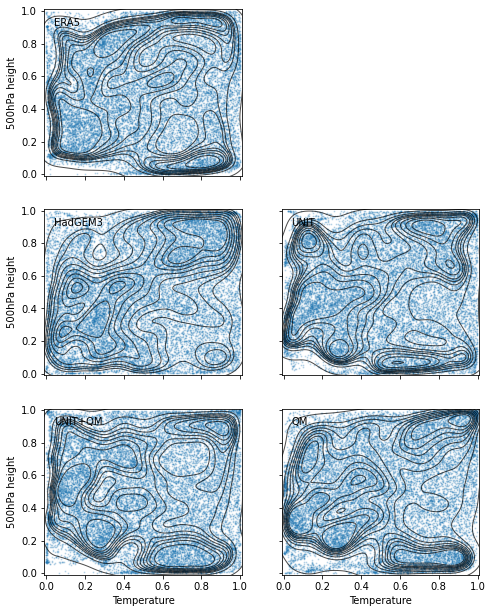

In [26]:
def _transform(ds):
    ds = ds.stack(z=("year", "lat", 'lon'))
    return ds.tasmax, ds.z500

plot_vrac([_transform(ds) for ds in hotest_days_data], xlabel="Temperature", ylabel="500hPa height", d=0.01)
plt.savefig("../data_analysis/figs/india_hotdays_joint_TP_vrac.png", dpi=300)
plt.show()

In [211]:
era_trans = transform_9(hotest_days_data[0])

for ds in hotest_days_data[1:]:
    val, bootvals = js_value_and_bootstrap_results(transform_9(ds), era_trans, n_bins=30)
    print(ds.attrs['title'], val, bootvals)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 288.32it/s]


HadGEM3 0.13696216968828395 [0.13888877 0.14249961 0.14668141]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 281.77it/s]


UNIT 0.12003177865302077 [0.12283333 0.12594684 0.12917305]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 287.09it/s]


UNIT+QM 0.06731840394369987 [0.07097401 0.07332577 0.07663308]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 281.69it/s]

QM 0.041095936658727475 [0.04524266 0.04740127 0.04945659]


# Figure 11 - River basin joint SPI

In [21]:
basin_path = '/home/s1205782/netcdf_store/Major_Basins_of_the_World/Major_Basins_of_the_World_clean.nc'
basins_ds = xr.open_dataset(basin_path)

In [22]:
basins_ds.basin

<xarray.DataArray 'basin' (basin: 226)>
array(['Alabama', 'Amazon', 'Amu Darya', ..., 'Zaire', 'Zambezi', 'Zarumilla'],
      dtype=object)
Coordinates:
  * basin    (basin) object 'Alabama' 'Amazon' ... 'Zambezi' 'Zarumilla'

In [23]:
def calculate_spi(ds, n_days):
    pr_ave = ds.pr.mean(dim=('lat', 'lon'))**0.25
    rolling_mean = pr_ave.rolling(time=n_days, center=False).mean().dropna("time")
    pr_time_mean = rolling_mean.mean('time')
    pr_std = rolling_mean.std(dim='time')
    SPI = (rolling_mean - pr_time_mean) / pr_std
    SPI.attrs['title'] = ds.attrs['title'] 
    return SPI

In [24]:
# Indus
def calculate_basin_spi(ds, basin, n_days):
    return calculate_spi(ds.where(basins_ds.sel(basin=basin).mask), n_days)

def basins_joint_spi(ds, n_days):
    i_spi = calculate_basin_spi(ds, 'Indus', n_days)
    gb_spi = calculate_basin_spi(ds, 'Ganges-Brahmaputra', n_days)
    return i_spi, gb_spi

basins_spis = [
    basins_joint_spi(ds, 30)
    for ds in [era, had, trans, combo, qm]
]

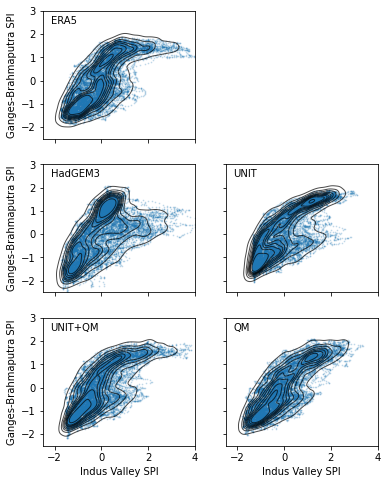

In [27]:
def SPI_river_subplots_newstyle(basins_spis, figsize=(6,8), kde=True, alpha=.2):
    
    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    
    axs[0, -1].axis('off')
    axs_used = axs.ravel()[[0,2,3,4,5]]
    
    xlim = (-2.5, 4)
    ylim = (-2.5, 3)
    

    for (x, y), ax in zip(basins_spis, axs_used):
        
        ax.annotate(x.attrs['title'], xy=(0.05, 0.9), xycoords='axes fraction')
        
        ax.plot(x, y, linestyle='', marker='.', alpha=alpha, markersize=1.6, zorder=-1);
        if kde:
            sns.kdeplot(x=x, y=y, ax=ax, color='k', linewidths=1, alpha=.7)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

    for ax in axs[:,0]:
        ax.set_ylabel('Ganges-Brahmaputra SPI')
    for ax in axs[-1,:]:
        ax.set_xlabel('Indus Valley SPI')



SPI_river_subplots_newstyle(basins_spis)
#plt.savefig("SPI_basins_jointdist_" + str(time) + "_newstyle.png", dpi=300)


<Figure size 432x288 with 0 Axes>

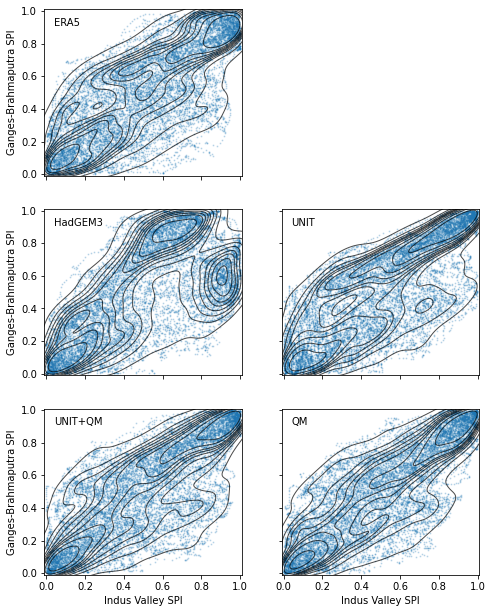

In [34]:
plot_vrac(
    basins_spis, 
    xlabel="Indus Valley SPI", 
    ylabel="Ganges-Brahmaputra SPI", 
    d=0.01
)

plt.savefig("../data_analysis/figs/SPI_basins_jointdist_newstyle_vrac.png", dpi=300)
plt.show()

In [223]:
for basin_spis in basins_spis[1:]:
    val, bootvals = js_value_and_bootstrap_results(basin_spis, basins_spis[0], n_bins=30)
    print(basin_spis[0].attrs['title'], val, bootvals)

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 105.33it/s]


HadGEM3 0.11188392944973517 [0.11423537 0.11830857 0.12247337]


100%|████████████████████████████████████████| 200/200 [00:01<00:00, 103.16it/s]


UNIT 0.07043090901305572 [0.07648828 0.08008716 0.08389156]


100%|████████████████████████████████████████| 200/200 [00:01<00:00, 102.75it/s]


UNIT+QM 0.04209681169957023 [0.04800114 0.05054238 0.053488  ]


100%|████████████████████████████████████████| 200/200 [00:01<00:00, 104.17it/s]

QM 0.05086838593969628 [0.05665657 0.05957312 0.06243743]


In [224]:
def every_n(ds_list, n, s=0):
    return [ds.isel(time=slice(s, None, n)) for ds in ds_list]

basins_spis_indep = [every_n(d, 30) for d in basins_spis]

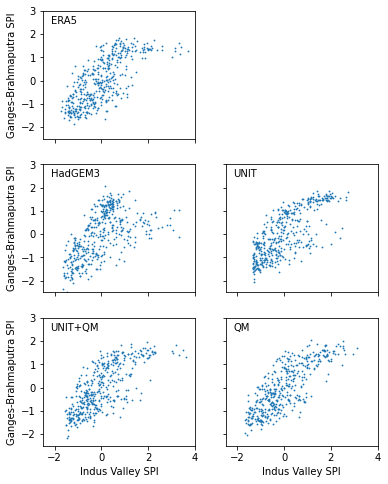

In [225]:
SPI_river_subplots_newstyle(basins_spis_indep, kde=False, alpha=1)

In [226]:

for basin_spis in basins_spis_indep[1:]:
    val, bootvals = js_value_and_bootstrap_results(basin_spis, basins_spis_indep[0], n_bins=10)
    print(basin_spis[0].attrs['title'], val, bootvals)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 226.37it/s]


HadGEM3 0.09993257669244149 [0.10634177 0.12613557 0.14999057]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 226.61it/s]


UNIT 0.06930433135093443 [0.08561019 0.10224549 0.12605699]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 222.61it/s]


UNIT+QM 0.03491136252761837 [0.05428558 0.06886846 0.08893114]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 225.76it/s]

QM 0.04206177055549709 [0.05722989 0.07579368 0.09216882]


# Figure 10 - PRECIP-TEMP JOINT DISTS 

In [30]:
# Slice out peak SPI for each year - NEEDS EDITING 
def spi_peak_months(ds, basin):
    
    ds = ds.where(basins_ds.sel(basin=basin).mask)
    
    spi = calculate_spi(ds, n_days=30)
    
    #wettest_periods = SPI_data.groupby(SPI_data.time.dt.year).max('time')
    def func(dx):
        time = dx.time.isel(time=dx.argmax(dim='time'))
        ind = (ds.time==time).argmax(dim='time')
        return ind
        
    time_inds = spi.groupby('time.year').apply(func).values
    
    # make sure we have no overlap problems
    assert not np.any(np.diff(time_inds)<30)
    
    return ds.rolling(time=30, center=False).mean().isel(time=time_inds)

In [31]:
peak_months_data = [
    spi_peak_months(ds, 'Ganges-Brahmaputra')
    for ds in [era, had, trans, combo, qm]
]

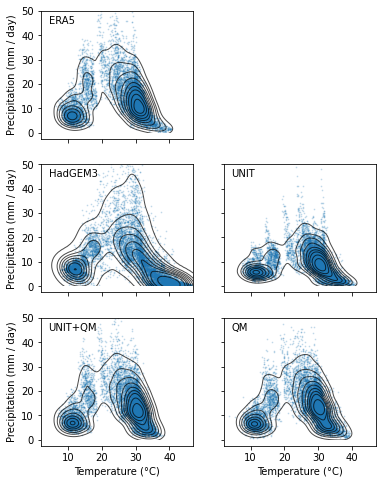

In [229]:
def mask_sub_zero(ax, mask_x, mask_y):
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    if mask_x and  ylim[0]<0:
        # mask x values below zero
        rect1 = matplotlib.patches.Rectangle(
            (xlim[0]-1, ylim[0]-1), 
            1-xlim[0], 
            2+ylim[1]-ylim[0], 
            color='white', 
            zorder=2
        )
        ax.add_patch(rect1)
    
    if mask_y and ylim[0]<0:
        # mask y values below zero
        rect2 = matplotlib.patches.Rectangle(
            (xlim[0]-1,ylim[0]-1), 
            2+xlim[1]-xlim[0], 
            1-ylim[0], 
            color='white', 
            zorder=2
        )
        ax.add_patch(rect2)
        
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

def basin_temp_pr_subplots_newstyle(ds_list, figsize=(6,8)):
    
    fig, axes = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    
    axes[0, -1].axis('off')
    axes_used = axes.ravel()[[0,2,3,4,5]]
    
    xlim = (2, 47)
    ylim = (-2.5, 50)
    

    for ds, ax in zip(ds_list, axes_used):
        x = ds.tasmax.values.ravel()
        y = ds.pr.values.ravel()
        label = ds.attrs['title']

        ax.annotate(label, xy=(0.05, 0.9), xycoords='axes fraction')
        
        ax.plot(x, y, linestyle='', marker='.', alpha=0.2, markersize=1.6, zorder=-1);
        sns.kdeplot(x=x, y=y, ax=ax, color='k', linewidths=1, alpha=.7)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        mask_sub_zero(ax, mask_x=False, mask_y=True)

        
    for ax in axes[:,0]:
        ax.set_ylabel('Precipitation (mm / day)')
    for ax in axes[-1,:]:
        ax.set_xlabel('Temperature (°C)')


#plt.savefig("GB_temp_pr_jointdist_new.png", dpi=300)


basin_temp_pr_subplots_newstyle(peak_months_data, figsize=(8, 8))

In [230]:
def transform_10(ds):
    x = ds.tasmax.values.ravel()
    y = ds.pr.values.ravel()
    mask = np.logical_or(np.isnan(x), np.isnan(y))
    return x[~mask], y[~mask]

d0 = transform_10(peak_months_data[0])

for ds in peak_months_data[1:]:
    val, bootvals = js_value_and_bootstrap_results(transform_10(ds), d0, n_bins=30)
    print(ds.attrs['title'], val, bootvals)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 548.79it/s]


HadGEM3 0.1977372599600864 [0.19578102 0.20102769 0.20629203]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 504.39it/s]


UNIT 0.0984755587875136 [0.10170522 0.10526311 0.10947752]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 508.14it/s]


UNIT+QM 0.019481236371519554 [0.0261953  0.02808258 0.03110507]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 504.21it/s]

QM 0.03329822380837673 [0.0391477  0.04322182 0.04739063]


In [36]:
peak_months_data[0]

<xarray.Dataset>
Dimensions:  (lat: 68, lon: 92, time: 35)
Coordinates:
  * lat      (lat) float64 -7.5 -6.944 -6.389 -5.833 ... 28.06 28.61 29.17 29.72
  * lon      (lon) float64 44.58 45.42 46.25 47.08 ... 117.9 118.8 119.6 120.4
  * time     (time) datetime64[ns] 1979-07-28 1980-08-11 ... 2013-07-22
    basin    <U18 'Ganges-Brahmaputra'
Data variables:
    pr       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    tasmax   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    z500     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  conservative
    title:          ERA5

<Figure size 432x288 with 0 Axes>

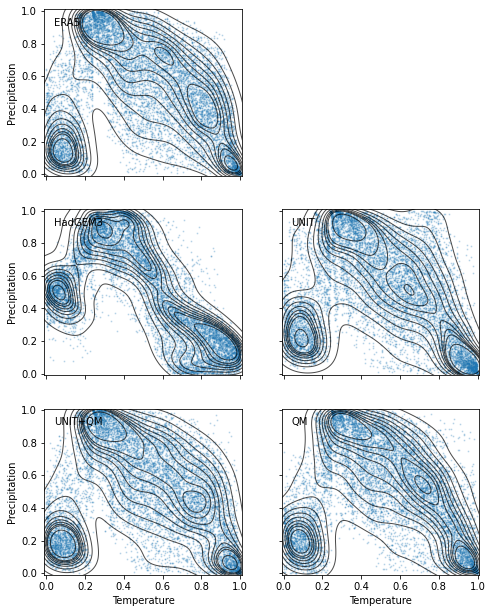

In [38]:
def _transform(ds):
    ds = ds.stack(z=("lat", 'lon', "time"))
    x = ds.tasmax
    y = ds.pr  
    return x, y

plot_vrac(
    [_transform(ds) for ds in peak_months_data], 
    xlabel="Temperature", 
    ylabel="Precipitation", 
    d=0.01
)

plt.savefig("../data_analysis/figs/GB_temp_pr_jointdist_new_vrac.png", dpi=300)
plt.show()